In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-12-28 13:44:23.812344: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-28 13:44:23.960284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-28 13:44:25.779909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/tripwireguy/PycharmProjects/Jordan_2018_car_accidents_weather/.venv/lib/python3.12/si

In [2]:
data_path = '../data/preprocessed_data_2010_2025.csv'

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,Datetime,Temperature,Wind Speed,Condition_Blowing Sand,Condition_Cloudy,Condition_Drizzle,Condition_Duststorm,Condition_Fair,Condition_Fog,Condition_Freezing Rain,...,Condition_Small Hail,Condition_Smoke,Condition_Snow,Condition_Snow Grains,Condition_Squalls,Condition_Thunder,Condition_Widespread Dust,Condition_Wintry Mix,WindDir_sin,WindDir_cos
0,2010-01-01 00:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.866025,-4.999999e-01
1,2010-01-01 01:00:00,10.000000,6.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-1.000000,1.192488e-08
2,2010-01-01 02:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
3,2010-01-01 03:00:00,10.000000,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01
4,2010-01-01 04:00:00,11.111111,7.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,-0.939693,-3.420201e-01


In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime')
df = df.set_index('Datetime')

In [6]:
target = 'Temperature'
features = ['Temperature', 'Wind Speed', 'WindDir_sin','WindDir_cos']

In [7]:
split_date = '2022-1-1'
train_df = df.loc[:split_date]
test_df = df.loc[split_date:]

In [8]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [9]:
X_train = X_scaler.fit_transform(train_df[features])
X_test = X_scaler.transform(test_df[features])

In [10]:
y_train = y_scaler.fit_transform(train_df[[target]])
y_test = y_scaler.transform(test_df[[target]])

In [11]:
WINDOW = 24

In [12]:
def make_sequence(X, y, window=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])

    return np.array(X_seq), np.array(y_seq)

In [13]:
X_train_seq, y_train_seq = make_sequence(X_train, y_train, window=WINDOW)

In [14]:
X_test_seq, y_test_seq = make_sequence(X_test, y_test, window=WINDOW)

In [15]:
model = Sequential([
    Input(shape=(X_test_seq.shape[1],X_test_seq.shape[2])),
    SimpleRNN(64,activation='tanh'),
    Dense(1, activation='linear')
])

In [16]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [18]:
model_checkpoint = ModelCheckpoint(
    '../models/rnn_best_model_full.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

In [19]:
model.fit(X_train_seq,
          y_train_seq,
         validation_split=0.1,
         epochs=25,
         batch_size=32,
         callbacks=[model_checkpoint, early_stopping])

Epoch 1/25


2025-12-28 13:44:31.556378: I external/local_xla/xla/service/service.cc:163] XLA service 0x76896c00a270 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-28 13:44:31.556407: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-12-28 13:44:31.596404: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  59/2931 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1115 - mae: 0.2398

I0000 00:00:1766918671.877211   17863 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2931/2931 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0022 - mae: 0.0283 - val_loss: 7.5292e-04 - val_mae: 0.0214
Epoch 2/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.6442e-04 - mae: 0.0194 - val_loss: 0.0015 - val_mae: 0.0326
Epoch 3/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.1769e-04 - mae: 0.0186 - val_loss: 7.7741e-04 - val_mae: 0.0214
Epoch 4/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.8397e-04 - mae: 0.0180 - val_loss: 5.5261e-04 - val_mae: 0.0175
Epoch 5/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.6723e-04 - mae: 0.0177 - val_loss: 5.7101e-04 - val_mae: 0.0176
Epoch 6/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 5.5393e-04 - mae: 0.0174 - val_loss: 4.8999e-04 - val_mae: 0.0160
Epoch 7/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.3534e-04 - mae: 0.0171 - val_loss: 5.3456e-04 - val_mae: 0.0170
Epoch 8/25
2931/2931 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.2894e-04 - mae: 0.0169 - val_loss: 6.2529e-04 - val_mae: 0

In [20]:
y_pred_scaled = model.predict(X_test_seq)

1089/1089 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [21]:
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test_seq)

In [22]:
mae = mean_absolute_error(y_true,y_pred)

In [23]:
mse = mean_squared_error(y_true,y_pred)

In [24]:
r2 = r2_score(y_true,y_pred)

In [32]:
print(f'{'RNN-Temp':-^30}')
print(f'{mae = :.5f}')
print(f'{mse = :.5f}')
print(f'{r2  = :.5f}')

-----------RNN-Temp-----------
mae = 0.71355
mse = 0.93318
r2  = 0.98600


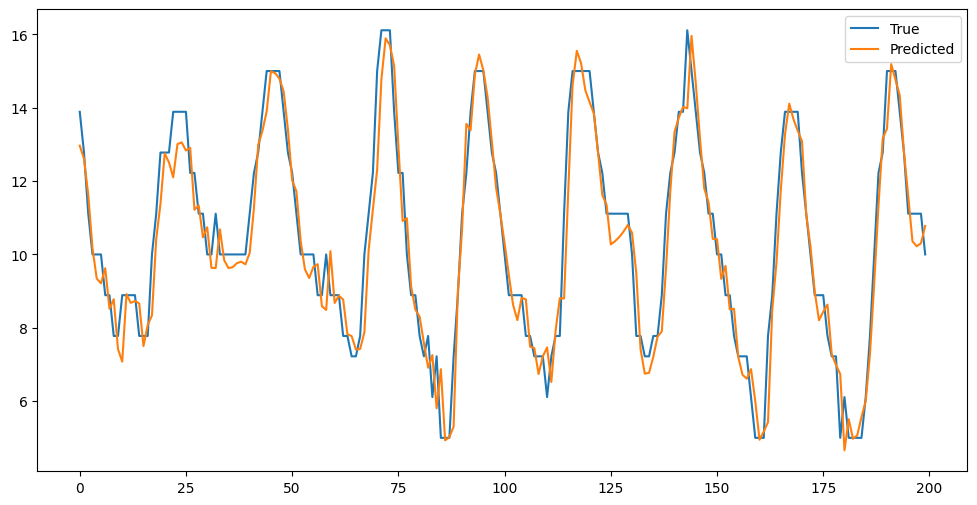

In [30]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_true[-200:], label='True')
ax.plot(y_pred[-200:], label='Predicted')
plt.legend()
plt.show()